In [1]:
%env MKL_NUM_THREADS=24
%env OMP_NUM_THREADS=24

env: MKL_NUM_THREADS=24
env: OMP_NUM_THREADS=24


In [2]:
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import random_grid, find_optimal_config
from polara.recommender.coldstart.models import ItemColdStartEvaluationMixin
from polara.recommender.external.turi.turiwrapper import (TuriFactorizationRecommender,
                                                          ColdStartRecommendationsMixin)

from data_preprocessing import (get_amazon_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)

%matplotlib inline

In [3]:
seed = 42

In [4]:
experiment_name = 'fm'

# Experiment setup

In [5]:
data_labels = ['AMZe', 'AMZvg']

In [6]:
# according to https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html
init_config = dict(with_data_feedback = False, # implicit case
                   ranking_optimization = True,
                   solver = 'adagrad',
                   sgd_step_size = 0, # let Turi autotune it
                   seed = seed,
                   max_iterations = 25,
                   other_tc_params = {}
                   )
fm_init_config = dict.fromkeys(data_labels, {'FM': init_config, # standard scenario
                                             'FM(cs)': init_config}) # cold start

In [7]:
params = {
          'regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'linear_regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'rank': [40] # for initial tuning (exploration)
         }

if init_config['solver'] == 'adagrad':
    params.update({
                   'adagrad_momentum_weighting': [0.9, 0.95, 0.99]
                  })

In [8]:
ranks_grid = [1, 5, 15, 30, 50, 75, 100, 150, 200, 250, 300, 400,
              500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

In [9]:
fm_ranks = {'AMZe': ranks_grid,
            'AMZvg': ranks_grid
           }

In [10]:
topk_values = [1, 3, 10, 20, 30]

In [11]:
target_metric = 'mrr'

In [12]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [13]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Amazon Electronics

In [14]:
lbl = 'AMZe'

In [15]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Electronics.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Electronics.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [16]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [17]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Amazon Video Games

In [18]:
lbl = 'AMZvg'

In [19]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('/mnt/bulky/datasets/recsys/amazon/ratings_Video_Games.csv',
                                                 meta_path='/mnt/bulky/datasets/recsys/amazon/meta/meta_Video_Games.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_data={'categories': ['Games']}, # filter uniformative category
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [20]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [21]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [22]:
print_data_stats(data_labels, all_data)

AMZe
{'userid': 124895, 'asin': 44843}
density 0.019153791836615672
similarity matrix density 1.1054998336712965
AMZvg
{'userid': 14251, 'asin': 6858}
density 0.13281340440589384
similarity matrix density 9.081814734274188


# Standard experiment

In [23]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    fm = TuriFactorizationRecommender(data_model, item_side_info=meta_dict[data_label])
    fm.method = 'FM'
    models = [fm]
    apply_config(models, config, data_label)
    return models

def fine_tune_fm(model, params, label, ntrials=60, record_time_as=None):
    param_grid, param_names = random_grid(params, n=ntrials)
    best_fm_config, fm_scores = find_optimal_config(model, param_grid, param_names,
                                                    target_metric,
                                                    return_scores=True,
                                                    force_build=True,
                                                    iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_fm_config))}
    model_scores = {model.method: fm_scores}
    try:
        if record_time_as:
            save_training_time(f'{experiment_name}_{record_time_as}', model, fm_scores.index, label)
    finally:
        return model_config, model_scores

## tuning

In [24]:
config = {}
scores = {}
times = {}
data_models = {}

In [25]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, fm_init_config)
    config[label], scores[label] = fine_tune_fm(model, params, label, ntrials=30, record_time_as='param')
del model

 [████████████████████████████████████████████████████████████] 2/2 [01:10:42<03:43, 2120.82s/it]

           AMZe [█████████████████████████████████████████████] 30/30 [01:06:48<02:10, 133.61s/it]

          AMZvg [█████████████████████████████████████████████] 30/30 [03:42<00:07, 7.41s/it]

/home/evfro/miniconda3/envs/polara_dev/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


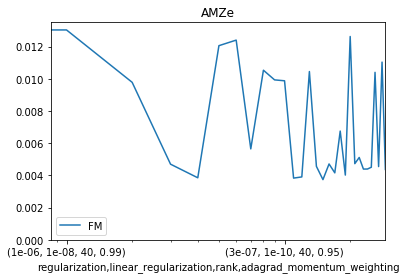

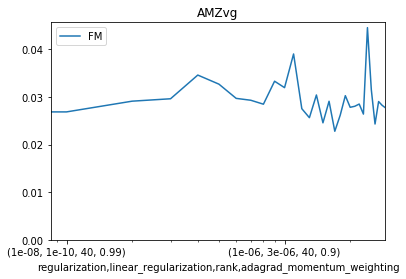

In [26]:
report_results('tuning', scores);

In [27]:
config

{'AMZe': {'FM': {'regularization': 1e-06,
   'linear_regularization': 1e-08,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}},
 'AMZvg': {'FM': {'regularization': 3e-06,
   'linear_regularization': 3e-06,
   'rank': 40,
   'adagrad_momentum_weighting': 0.99}}}

### saving data

In [28]:
save_results(f'{experiment_name}_param', config=config, tuning=scores)

## rank estimation

In [29]:
rank_config = {}
rank_scores = {}

In [30]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models,
                                        [fm_init_config, config]) # initiate with optimal config
    rank_config[label], rank_scores[label] = fine_tune_fm(model, {'rank': fm_ranks[label]},
                                                          label, ntrials=0, record_time_as='rank')
del model

 [████████████████████████████████████████████████████████████] 2/2 [04:08:56<15:27, 7468.04s/it]

           AMZe [█████████████████████████████████████████████] 21/21 [03:53:29<05:06, 667.08s/it]

          AMZvg [█████████████████████████████████████████████] 21/21 [15:27<00:24, 44.16s/it]

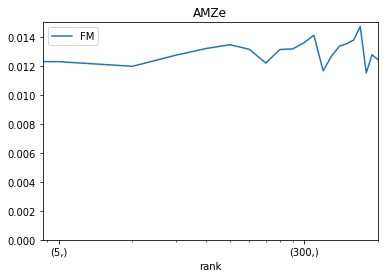

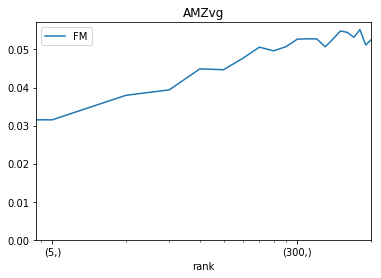

In [31]:
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores.items() for k, v in scr.items()});

In [32]:
rank_config

{'AMZe': {'FM': {'rank': 1750}}, 'AMZvg': {'FM': {'rank': 2000}}}

### saving data

In [33]:
save_results(f'{experiment_name}_rank', config=rank_config, tuning=rank_scores)

## cross-validation

In [34]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, [fm_init_config, config, rank_config])
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 2/2 [02:08:11<09:06, 3845.47s/it]

           AMZe [█████████████████████████████████████████████] 5/5 [01:59:05<23:46, 1429.06s/it]

          AMZvg [█████████████████████████████████████████████] 5/5 [09:06<01:50, 109.10s/it]

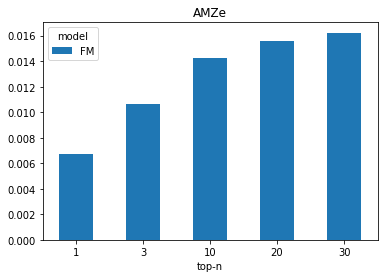

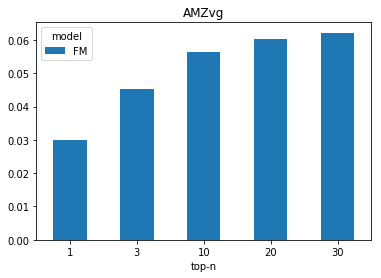

In [35]:
report_results('topn', result, target_metric);

In [36]:
pd.concat({lbl: res.mean(level='top-n').loc[10, :'ranking'] for lbl, res in result.items()}, axis=1)

,,AMZe,AMZvg
type,metric,,
relevance,hr,0.037263,0.132833
ranking,mrr,0.014212,0.056403


### saving data

In [37]:
save_results(experiment_name, cv=result)

# Cold start

In [38]:
class TuriRecommenderColdStart(ItemColdStartEvaluationMixin,
                               ColdStartRecommendationsMixin,
                               TuriFactorizationRecommender): pass

def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    fm = TuriRecommenderColdStart(data_model, item_side_info=meta_dict[data_label])
    fm.method = 'FM(cs)'
    models = [fm]
    apply_config(models, config, data_label)
    return models

## tuning

In [39]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [40]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model, =  prepare_cold_start_recommender_models(label, data_models_cold, fm_init_config)
    config_cold[label], scores_cold[label] = fine_tune_fm(model, params, label, ntrials=30)
del model

 [████████████████████████████████████████████████████████████] 2/2 [23:50:05<23:31, 42902.75s/it]

           AMZe [█████████████████████████████████████████████] 30/30 [23:26:29<48:23, 2812.98s/it]

          AMZvg [█████████████████████████████████████████████] 30/30 [23:30<00:39, 47.01s/it]

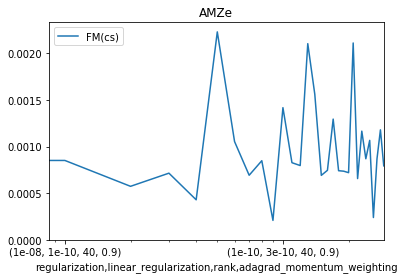

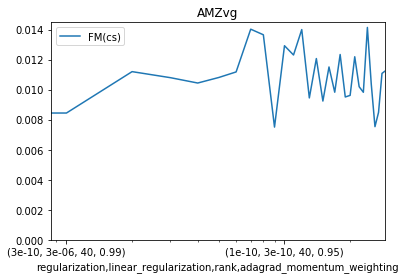

In [41]:
# (multiple) last cats, default neg sampling
report_results('tuning', scores_cold);

In [42]:
config_cold

{'AMZe': {'FM(cs)': {'regularization': 3e-06,
   'linear_regularization': 3e-08,
   'rank': 40,
   'adagrad_momentum_weighting': 0.95}},
 'AMZvg': {'FM(cs)': {'regularization': 1e-09,
   'linear_regularization': 1e-10,
   'rank': 40,
   'adagrad_momentum_weighting': 0.95}}}

### saving data

In [43]:
save_results(f'{experiment_name}_coldstart_param', config=config_cold, tuning=scores_cold)

## rank estimation

In [44]:
rank_config_cold = {}
rank_scores_cold = {}

In [45]:
for label in track(data_labels):
    model, = prepare_cold_start_recommender_models(label, data_models_cold,
                                                   [fm_init_config, config_cold]) # initiate with optimal config
    rank_config_cold[label], rank_scores_cold[label] = fine_tune_fm(model, {'rank': fm_ranks[label]},
                                                                    label, ntrials=0)
del model

 [████████████████████████████████████████████████████████████] 2/2 [19:42:33<28:59, 35476.52s/it]

           AMZe [█████████████████████████████████████████████] 21/21 [19:13:34<46:09, 3295.92s/it]

          AMZvg [█████████████████████████████████████████████] 21/21 [28:59<01:01, 82.79s/it]

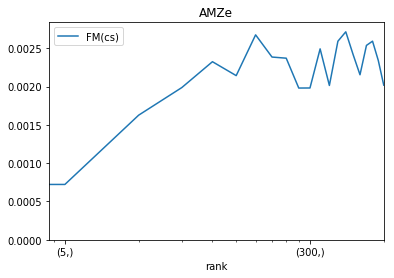

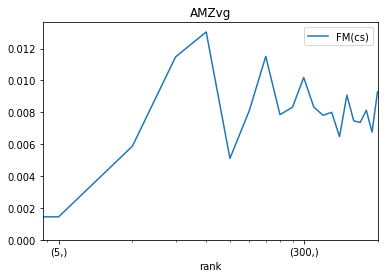

In [46]:
# (multiple) last cats, default neg sampling
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores_cold.items() for k, v in scr.items()});

In [47]:
rank_config_cold

{'AMZe': {'FM(cs)': {'rank': 1000}}, 'AMZvg': {'FM(cs)': {'rank': 50}}}

### saving data

In [48]:
save_results(f'{experiment_name}_coldstart_rank', config=rank_config_cold, tuning=rank_scores_cold)

## cross validation

In [49]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold,
                                                        [fm_init_config, config_cold, rank_config_cold])
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=label))

 [████████████████████████████████████████████████████████████] 2/2 [05:11:58<03:29, 9359.12s/it]

           AMZe [█████████████████████████████████████████████] 5/5 [05:08:29<01:06:39, 3701.76s/it]

          AMZvg [█████████████████████████████████████████████] 5/5 [03:29<00:42, 41.88s/it]

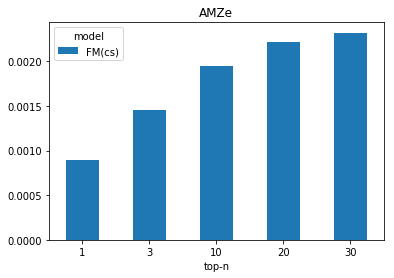

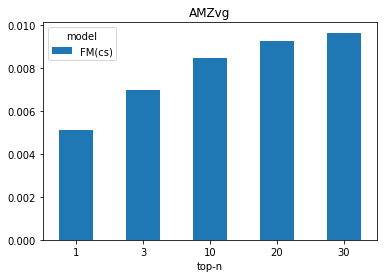

In [50]:
# (multiple) last cats, default neg sampling
report_results('topn', result_cold, target_metric);

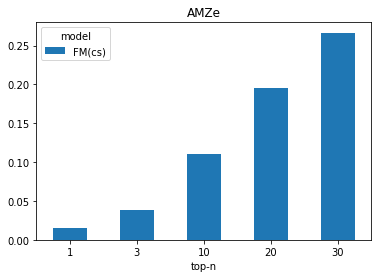

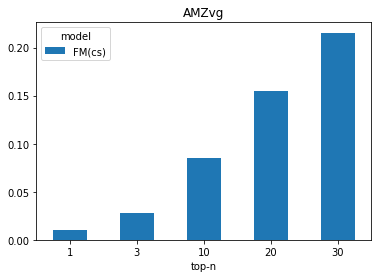

In [51]:
report_results('topn', result_cold, 'coverage');

### saving data

In [52]:
save_results(f'{experiment_name}_coldstart', cv=result_cold)